# EECS 498-007/598-005 Assignment 2-2: Two Layer Neural Network

## Implementing a Neural Network
In this exercise we will develop a neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.

We train the network with a softmax loss function and L2 regularization on the weight matrices. The network uses a ReLU nonlinearity after the first fully connected layer. 

In other words, the network has the following architecture:

  input - fully connected layer - ReLU - fully connected layer - softmax

The outputs of the second fully-connected layer are the scores for each class.

**Note:** When you implment the regularization over W, please DO NOT multiply the regularization term by 1/2 (no coefficient). 






## Install starter code
We will continue using the utility functions that we've used for Assignment 1: [`coutils` package](https://github.com/deepvision-class/starter-code). Run this cell to download and install it.


In [1]:
!pip install git+https://github.com/deepvision-class/starter-code

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-q11kw705
  Running command git clone -q https://github.com/deepvision-class/starter-code /tmp/pip-req-build-q11kw705
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-py3-none-any.whl size=10308 sha256=4ffb5f5b8c68ddc7ce98e7569c2231e15017c8013f980b37a393c2262ede69ca
  Stored in directory: /tmp/pip-ephem-wheel-cache-wrt4puwd/wheels/eb/3c/88/465b0d78ef4a63d1f487c4208bd4691a448f05923eda0ef5f6
Successfully built Colab-Utils


## Setup code
Run some setup code for this notebook: Import some useful packages and increase the default figure size.


In [2]:
from __future__ import print_function
from __future__ import division

import torch
import coutils
import random
import math
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# for plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [3]:
if torch.cuda.is_available:
  print('Good to go!')
  print(torch.cuda.get_device_name(0))
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!
Tesla T4


The inputs to our network will be a batch of $N$ (`num_inputs`) $D$-dimensional vectors (`input_size`); the hidden layer will have $H$ hidden units (`hidden_size`), and we will predict classification scores for $C$ categories (`num_classes`). This means that the learnable weights and biases of the network will have the following shapes:

*   W1: First layer weights; has shape (D, H)
*   b1: First layer biases; has shape (H,)
*   W2: Second layer weights; has shape (H, C)
*   b2: Second layer biases; has shape (C,)

We will use the following function to generate random weights for a small toy model while we implement the model:

In [4]:
def get_toy_data(num_inputs=5, input_size=4, hidden_size=10, num_classes=3,
                 dtype=torch.float32):
  N = num_inputs
  D = input_size
  H = hidden_size
  C = num_classes
 
  # We set the random seed for repeatable experiments.
  coutils.utils.fix_random_seed()
  
  # Generate some random parameters, storing them in a dict
  params = {}
  params['W1'] = 1e-4 * torch.randn(D, H, device='cuda').to(dtype)
  params['b1'] = torch.zeros(H, device='cuda').to(dtype)
  params['W2'] = 1e-4 * torch.randn(H, C, device='cuda').to(dtype)
  params['b2'] = torch.zeros(C, device='cuda').to(dtype)

  # Generate some random inputs and labels
  toy_X = 10.0 * torch.randn(N, D, device='cuda').to(dtype)
  toy_y = torch.tensor([0, 1, 2, 2, 1], dtype=torch.int64, device='cuda')
  
  return toy_X, toy_y, params

## Forward pass: compute scores
Like in the Linear Classifiers exercise, we want to write a function that takes as input the model weights and a batch of images and labels, and returns the loss and the gradient of the loss with respect to each model parameter.

However rather than attempting to implement the entire function at once, we will take a staged approach and ask you to implement the full forward and backward pass one step at a time.

First we will implement the forward pass of the network which uses the weights and biases to compute scores for all inputs:


In [5]:
def nn_loss_part1(params, X, y=None, reg=0.0):
    """
    The first stage of our neural network implementation: Run the forward pass
    of the network to compute the hidden layer features and classification
    scores. The network architecture should be:
    
    FC layer -> ReLU (hidden) -> FC layer (scores)

    Inputs:
    - params: a dictionary of PyTorch Tensor that store the weights of a model.
      It should have following keys with shape
          W1: First layer weights; has shape (D, H)
          b1: First layer biases; has shape (H,)
          W2: Second layer weights; has shape (H, C)
          b2: Second layer biases; has shape (C,)
    - X: Input data of shape (N, D). Each X[i] is a training sample.
    - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
      an integer in the range 0 <= y[i] < C. This parameter is optional; if it
      is not passed then we only return scores, and if it is passed then we
      instead return the loss and gradients.
    - reg: Regularization strength.

    Returns a tuple of:
    - scores: Tensor of shape (N, C) giving the classification scores for X
    - hidden: Tensor of shape (N, H) giving the hidden layer representation
      for each input value (after the ReLU).
    """
    # Unpack variables from the params dictionary
    W1, b1 = params['W1'], params['b1']
    W2, b2 = params['W2'], params['b2']
    N, D = X.shape

    # Compute the forward pass
    hidden = None
    scores = None
    #############################################################################
    # TODO: Perform the forward pass, computing the class scores for the input. #
    # Store the result in the scores variable, which should be an tensor of     #
    # shape (N, C).                                                             #
    #############################################################################
    # Replace "pass" statement with your code
    hidden = torch.nn.functional.relu(X.mm(W1) + b1)
    scores = hidden.mm(W2) + b2
    #############################################################################
    #                              END OF YOUR CODE                             #
    #############################################################################
    
    return scores, hidden

Compute the scores and compare with the answer. The distance gap should be smaller than 1e-10.

In [6]:
toy_X, toy_y, params = get_toy_data()

scores, _ = nn_loss_part1(params, toy_X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = torch.tensor([
        [-3.8160e-07,  1.9975e-07,  1.0911e-07],
        [-5.0228e-08,  1.2784e-07, -5.2746e-08],
        [-5.9560e-07,  9.1178e-07,  1.1879e-06],
        [-3.2737e-08,  1.8820e-07, -2.8079e-07],
        [-1.9523e-07,  2.0502e-07, -6.0692e-08]], dtype=torch.float32, device=scores.device)
print(correct_scores)
print()

# The difference should be very small. We get < 1e-10
scores_diff = (scores - correct_scores).abs().sum().item()
print('Difference between your scores and correct scores: %.2e' % scores_diff)

Your scores:
tensor([[ 9.7003e-08, -1.1143e-07, -3.9961e-08],
        [-7.4297e-08,  1.1502e-07,  1.5685e-07],
        [-2.5860e-07,  2.2765e-07,  3.2453e-07],
        [-4.7257e-07,  9.0935e-07,  4.0368e-07],
        [-1.8395e-07,  7.9303e-08,  6.0360e-07]], device='cuda:0')

correct scores:
tensor([[-3.8160e-07,  1.9975e-07,  1.0911e-07],
        [-5.0228e-08,  1.2784e-07, -5.2746e-08],
        [-5.9560e-07,  9.1178e-07,  1.1879e-06],
        [-3.2737e-08,  1.8820e-07, -2.8079e-07],
        [-1.9523e-07,  2.0502e-07, -6.0692e-08]], device='cuda:0')

Difference between your scores and correct scores: 5.72e-06


## Forward pass: compute loss
Now, we implement the first part of `nn_loss_part2` that computes the data and regularization loss.

For the data loss, we will use the softmax loss. For the regularization loss we will use L2 regularization on the weight matrices `W1` and `W2`; we will not apply regularization loss to the bias vectors `b1` and `b2`.

In [7]:
def nn_loss_part2(params, X, y=None, reg=0.0):
    """
    Compute the loss and gradients for a two layer fully connected neural
    network.

    Inputs: Same as nn_loss_part1
  
    Returns:
    If y is None, return a tensor scores of shape (N, C) where scores[i, c] is
    the score for class c on input X[i].

    If y is not None, instead return a tuple of:
    - loss: Loss (data loss and regularization loss) for this batch of training
      samples.
    - grads: Dictionary mapping parameter names to gradients of those parameters
      with respect to the loss function; has the same keys as self.params.

    - scores: Tensor of shape (N, C) giving the classification scores for X
    """
    # Unpack variables from the params dictionary
    W1, b1 = params['W1'], params['b1']
    W2, b2 = params['W2'], params['b2']
    N, D = X.shape

    scores, hidden1 = nn_loss_part1(params, X, y, reg)
    # If the targets are not given then jump out, we're done
    if y is None:
      return scores

    # Compute the loss
    loss = None
    #############################################################################
    # TODO: Finish the forward pass, and compute the loss. This should include  #
    # both the data loss and L2 regularization for W1 and W2. Store the result  #
    # in the variable loss, which should be a scalar. Use the Softmax           #
    # classifier loss. When you implment the regularization over W, please DO   #
    # NOT multiply the regularization term by 1/2 (no coefficient). If you are  #
    # not careful here, it is easy to run into numeric instability (Check       #
    # Numeric Stability in http://cs231n.github.io/linear-classify/).           #
    #############################################################################
    # Replace "pass" statement with your code
    stable_coefs = scores - torch.amax(scores, dim=1, keepdim=True)
    Z = torch.exp(stable_coefs).sum(dim=1, keepdim=True)
    log_probs = stable_coefs - torch.log(Z)
    probs = torch.exp(log_probs)

    loss_scores = (-1.0 / N) * log_probs[torch.arange(N), y].sum()
    W1_loss = torch.sum(W1*W1)
    W2_loss = torch.sum(W2*W2)

    loss = loss_scores + reg * (W1_loss + W2_loss)
    #############################################################################
    #                              END OF YOUR CODE                             #
    #############################################################################

    # Backward pass: compute gradients
    grads = {}
    #############################################################################
    # TODO: Compute the backward pass, computing the derivatives of the weights #
    # and biases. Store the results in the grads dictionary. For example,       #
    # grads['W1'] should store the gradient on W1, and be a tensor of same size #
    #############################################################################
    # Network Architecture
    # X             ->
    # W1,b1         ->
    # t             ->
    # RelU          -> 
    # hidden1       -> 
    # W2,b2         ->
    # scores        ->
    # Softmax       -> 
    # probs         ->
    # Cross_entropy ->
    # L
    # ====== BACKWARD ======
    grad_L = 1.0
    
    # ---- Cross_entropy ----
    # Efficiency can be improved:
    mask = torch.zeros(probs.shape, device='cuda')
    mask[torch.arange(N), y] = 1
    grad_probs = (1.0 / N) * (-1.0 / probs) * mask * grad_L

    # ---- Softmax ----
    grad_scores = probs * (grad_probs - (grad_probs * probs).sum(dim=1, keepdim=True))

    # ---- Linear2 ----
    grad_W2 = (hidden1.t()).mm(grad_scores) + 2 * reg * W2
    grad_b2 = (torch.ones_like(b2) * grad_scores).sum(dim=0)
    grad_hidden1 = grad_scores.mm(W2.t())

    # ---- ReLU ----
    mask_relu = torch.zeros_like(hidden1, device='cuda')
    mask_relu[hidden1 > 0] = 1
    grad_t = grad_hidden1 * mask_relu

    # ---- Linear1 ----
    grad_W1 = X.t().mm(grad_t) + 2 * reg * W1
    grad_b1 = (torch.ones_like(hidden1) * grad_t).sum(dim=0)

    grads['W2'] = grad_W2
    grads['b2'] = grad_b2
    grads['W1'] = grad_W1
    grads['b1'] = grad_b1

    #############################################################################
    #                              END OF YOUR CODE                             #
    #############################################################################

    return loss, grads

---

**How to slice tensor**

In [8]:
# Selecting the first column:
a = torch.rand(6, 5)
print(a)
y = torch.zeros(6, dtype=torch.long)

a[torch.arange(6), y]

tensor([[0.4963, 0.7682, 0.0885, 0.1320, 0.3074],
        [0.6341, 0.4901, 0.8964, 0.4556, 0.6323],
        [0.3489, 0.4017, 0.0223, 0.1689, 0.2939],
        [0.5185, 0.6977, 0.8000, 0.1610, 0.2823],
        [0.6816, 0.9152, 0.3971, 0.8742, 0.4194],
        [0.5529, 0.9527, 0.0362, 0.1852, 0.3734]])


tensor([0.4963, 0.6341, 0.3489, 0.5185, 0.6816, 0.5529])

---

First, implement the forward pass in the function `nn_loss_part2` above. Then run the following to check your implementation.

We compute the loss for the toy data, and compare with the answer computed by our implementation. The difference between the correct and computed **loss** should be less than `1e-4`.

In [9]:
toy_X, toy_y, params = get_toy_data()

loss, _ = nn_loss_part2(params, toy_X, toy_y, reg=0.05)
print('Your loss: ', loss.item())
correct_loss = 1.0986
print('Correct loss: ', correct_loss)
diff = (correct_loss - loss).item()

# should be very small, we get < 1e-4
print('Difference: %.4e' % diff)

Your loss:  1.0986121892929077
Correct loss:  1.0986
Difference: -1.2159e-05


## Backward pass
Now implement the backward pass for the entire network in `nn_loss_part2`.

After doing so, we will use numeric gradient checking to see whether the analytic gradient computed by our backward pass mateches a numeric gradient.


First we define a couple utility functions for our numeric gradient check:


In [10]:
def compute_numeric_gradient(f, x, h=1e-7):
  """ 
  Compute the numeric gradient of f at x using a finite differences
  approximation. We use the centered difference:
  
  df/dx ~= (f(x + h) - f(x - h)) / (2 * h)
  
  Inputs:
  - f: A function that inputs a torch tensor and returns a torch scalar
  - x: A torch tensor giving the point at which to compute the gradient

  Returns:
  - grad: A tensor of the same shape as x giving the gradient of f at x
  """ 
  fx = f(x) # evaluate function value at original point
  flat_x = x.contiguous().view(-1)
  grad = torch.zeros_like(x)
  flat_grad = grad.view(-1)
  # iterate over all indexes in x
  for i in range(flat_x.shape[0]):
    oldval = flat_x[i].item() # Store the original value
    flat_x[i] = oldval + h    # Increment by h
    fxph = f(x).item()        # Evaluate f(x + h)
    flat_x[i] = oldval - h    # Decrement by h
    fxmh = f(x).item()        # Evaluate f(x - h)
    flat_x[i] = oldval        # Restore original value

    # compute the partial derivative with centered formula
    flat_grad[i] = (fxph - fxmh) / (2 * h)

  return grad


def rel_error(x, y, eps=1e-10):
  """ returns relative error between x and y """
  top = (x - y).abs().max().item()
  bot = (x.abs() + y.abs()).clamp(min=eps).max().item()
  return top / bot

---
**Numeric gradient of scalar function**



In [11]:
def custom_f(x, y):
  loss = (x*x).sum()
  grad = 2*x

  return loss, grad


N = 5
toy_y = torch.tensor([1, 2, 1, 4, 5])
toy_X = torch.rand((5,5), device='cuda', dtype=torch.float64)
# !!Remember to add enough numerical precision (torch.float64)!!

f = lambda x: custom_f(x, toy_y)[0]

grad = custom_f(toy_X, toy_y)[1]
grad_numeric = compute_numeric_gradient(f, toy_X)
error = rel_error(grad, grad_numeric)
print(f"Grad: \n {grad}")
print(f"Grad numeric:\n {grad_numeric}")
print('max relative error: %e' % (error))

Grad: 
 tensor([[0.8302, 1.2501, 1.8410, 0.8369, 1.5910],
        [0.6307, 1.9162, 0.6358, 1.9695, 1.0815],
        [1.4992, 0.8787, 1.3081, 0.7665, 1.5594],
        [0.7868, 0.7830, 0.5202, 1.3507, 1.7737],
        [0.1646, 0.2420, 0.6345, 1.1553, 1.4696]], device='cuda:0',
       dtype=torch.float64)
Grad numeric:
 tensor([[0.8302, 1.2501, 1.8410, 0.8369, 1.5910],
        [0.6307, 1.9162, 0.6358, 1.9695, 1.0815],
        [1.4992, 0.8787, 1.3081, 0.7665, 1.5594],
        [0.7868, 0.7830, 0.5202, 1.3507, 1.7737],
        [0.1646, 0.2420, 0.6345, 1.1553, 1.4696]], device='cuda:0',
       dtype=torch.float64)
max relative error: 1.690106e-09


---

___
**Debugging Backprop**

In [12]:
a = torch.rand(5, 5)
b = a.sum(dim=1, keepdim=True)
print(a)
print(b.shape)

tensor([[0.4963, 0.7682, 0.0885, 0.1320, 0.3074],
        [0.6341, 0.4901, 0.8964, 0.4556, 0.6323],
        [0.3489, 0.4017, 0.0223, 0.1689, 0.2939],
        [0.5185, 0.6977, 0.8000, 0.1610, 0.2823],
        [0.6816, 0.9152, 0.3971, 0.8742, 0.4194]])
torch.Size([5, 1])


In order to debug, the network block's are implemented in steps and their gradients checked in backward order:

In [13]:
def custom_f(inp, y=None):
    # Network Architecture
    # X             ->
    # W1,b1         ->
    # t             ->
    # RelU          -> 
    # hidden1       -> 
    # W2,b2         ->
    # scores        ->
    # Softmax       -> 
    # probs         ->
    # Cross_entropy ->
    # L

    N, D = inp.shape
    loss = None
    grad = None
    grad_L = 1.0

    # ====== FORWARD ======
    scores = inp

    # ---- Softmax ----
    stable_coefs = scores - torch.amax(scores, dim=1, keepdim=True)
    Z = torch.exp(stable_coefs).sum(dim=1, keepdim=True)
    log_probs = stable_coefs - torch.log(Z)
    probs = torch.exp(log_probs)

    # ---- Cross_entropy ----
    # probs = inp
    # log_probs = torch.log(probs)
    loss_scores = (-1.0 / N) * log_probs[torch.arange(N), y].sum()
    loss = loss_scores


    # ====== BACKWARD ======

    # ---- Cross_entropy ----
    # Efficiency can be improved: ---
    mask = torch.zeros(probs.shape, device='cuda')
    mask[torch.arange(N), y] = 1
    grad_probs = (1.0 / N) * (-1.0 / probs) * mask * grad_L

    # ---- Softmax ----
    grad_scores = probs * (grad_probs - (grad_probs * probs).sum(dim=1, keepdim=True))

    # ---

    grad = grad_scores

    return loss, grad

In [14]:
toy_X, toy_y, params = get_toy_data(dtype=torch.float64)
toy_X = torch.rand(toy_X.shape, device='cuda', dtype=torch.float64)

f = lambda x: custom_f(x, toy_y)[0]

grad = custom_f(toy_X, toy_y)[1]
grad_numeric = compute_numeric_gradient(f, toy_X)
error = rel_error(grad, grad_numeric)
print(f"Grad: \n {grad}")
print(f"Grad numeric:\n {grad_numeric}")
print('max relative error: %e' % (error))

Grad: 
 tensor([[-0.1591,  0.0504,  0.0677,  0.0410],
        [ 0.0586, -0.1638,  0.0689,  0.0363],
        [ 0.0664,  0.0426, -0.1475,  0.0385],
        [ 0.0545,  0.0416, -0.1382,  0.0420],
        [ 0.0413, -0.1638,  0.0548,  0.0677]], device='cuda:0',
       dtype=torch.float64)
Grad numeric:
 tensor([[-0.1591,  0.0504,  0.0677,  0.0410],
        [ 0.0586, -0.1638,  0.0689,  0.0363],
        [ 0.0664,  0.0426, -0.1475,  0.0385],
        [ 0.0545,  0.0416, -0.1382,  0.0420],
        [ 0.0413, -0.1638,  0.0548,  0.0677]], device='cuda:0',
       dtype=torch.float64)
max relative error: 2.823609e-09


___

Now we will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check.

You should see relative errors less than `1e-4` for all parameters.

In [15]:
reg = 0.1
toy_X, toy_y, params = get_toy_data(dtype=torch.float64)
loss, grads = nn_loss_part2(params, toy_X, toy_y, reg=reg)

for param_name, grad in grads.items():
  param = params[param_name]
  f = lambda w: nn_loss_part2(params, toy_X, toy_y, reg=reg)[0]
  grad_numeric = compute_numeric_gradient(f, param)
  error = rel_error(grad, grad_numeric)
  print('%s max relative error: %e' % (param_name, error))

W2 max relative error: 1.097100e-06
b2 max relative error: 3.845715e-09
W1 max relative error: 1.321328e-06
b1 max relative error: 1.020074e-05


## Train the network
To train the network we will use stochastic gradient descent (SGD), similar to the SVM and Softmax classifiers. Look at the function `nn_train` and fill in the missing sections to implement the training procedure. This should be very similar to the training procedure you used for the SVM and Softmax classifiers. 

In [16]:
def nn_train(params, loss_func, pred_func, X, y, X_val, y_val,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=5e-6, num_iters=100,
            batch_size=200, verbose=False):
  """
  Train this neural network using stochastic gradient descent.

  Inputs:
  - params: a dictionary of PyTorch Tensor that store the weights of a model.
    It should have following keys with shape
        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)
  - loss_func: a loss function that computes the loss and the gradients.
    It takes as input:
    - params: Same as input to nn_train
    - X_batch: A minibatch of inputs of shape (B, D)
    - y_batch: Ground-truth labels for X_batch
    - reg: Same as input to nn_train
    And it returns a tuple of:
      - loss: Scalar giving the loss on the minibatch
      - grads: Dictionary mapping parameter names to gradients of the loss with
        respect to the corresponding parameter.
  - pred_func: prediction function that im
  - X: A PyTorch tensor of shape (N, D) giving training data.
  - y: A PyTorch tensor f shape (N,) giving training labels; y[i] = c means that
    X[i] has label c, where 0 <= c < C.
  - X_val: A PyTorch tensor of shape (N_val, D) giving validation data.
  - y_val: A PyTorch tensor of shape (N_val,) giving validation labels.
  - learning_rate: Scalar giving learning rate for optimization.
  - learning_rate_decay: Scalar giving factor used to decay the learning rate
    after each epoch.
  - reg: Scalar giving regularization strength.
  - num_iters: Number of steps to take when optimizing.
  - batch_size: Number of training examples to use per step.
  - verbose: boolean; if true print progress during optimization.
  
  Returns: A dictionary giving statistics about the training process
  """
  num_train = X.shape[0]
  iterations_per_epoch = max(num_train // batch_size, 1)

  # Use SGD to optimize the parameters in self.model
  loss_history = []
  train_acc_history = []
  val_acc_history = []

  for it in range(num_iters):
    X_batch = None
    y_batch = None

    #########################################################################
    # TODO: Create a random minibatch of training data and labels, storing  #
    # them in X_batch and y_batch respectively.                             #
    # hint: torch.randint                                                   #
    #########################################################################
    # Replace "pass" statement with your code
    batch_idx = torch.randint(0, num_train, (batch_size,))
    # still fine if batch_size > num_train
    X_batch = X[batch_idx, :]
    y_batch = y[batch_idx]
    #########################################################################
    #                             END OF YOUR CODE                          #
    #########################################################################

    # Compute loss and gradients using the current minibatch
    # print(loss_func(params, X_batch, y=y_batch, reg=reg))
    loss, grads = loss_func(params, X_batch, y=y_batch, reg=reg)
    loss_history.append(loss.item())

    #########################################################################
    # TODO: Use the gradients in the grads dictionary to update the         #
    # parameters of the network (stored in the dictionary self.params)      #
    # using stochastic gradient descent. You'll need to use the gradients   #
    # stored in the grads dictionary defined above.                         #
    #########################################################################
    # Replace "pass" statement with your code
    for key in params:
      params[key] -= learning_rate * grads[key]
    #########################################################################
    #                             END OF YOUR CODE                          #
    #########################################################################

    if verbose and it % 100 == 0:
      print('iteration %d / %d: loss %f' % (it, num_iters, loss.item()))

    # Every epoch, check train and val accuracy and decay learning rate.
    if it % iterations_per_epoch == 0:
      # Check accuracy
      y_train_pred = pred_func(params, loss_func, X_batch)
      train_acc = (y_train_pred == y_batch).float().mean().item()
      y_val_pred = pred_func(params, loss_func, X_val)
      val_acc = (y_val_pred == y_val).float().mean().item()
      train_acc_history.append(train_acc)
      val_acc_history.append(val_acc)

      # Decay learning rate
      learning_rate *= learning_rate_decay

  return {
    'loss_history': loss_history,
    'train_acc_history': train_acc_history,
    'val_acc_history': val_acc_history,
  }

You will also have to implement `nn_predict`, as the training process periodically performs prediction to keep track of accuracy over time while the network trains.

In [17]:
def nn_predict(params, loss_func, X):
  """
  Use the trained weights of this two-layer network to predict labels for
  data points. For each data point we predict scores for each of the C
  classes, and assign each data point to the class with the highest score.

  Inputs:
  - params: a dictionary of PyTorch Tensor that store the weights of a model.
    It should have following keys with shape
        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)
  - loss_func: a loss function that computes the loss and the gradients
  - X: A PyTorch tensor of shape (N, D) giving N D-dimensional data points to
    classify.

  Returns:
  - y_pred: A PyTorch tensor of shape (N,) giving predicted labels for each of
    the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
    to have class c, where 0 <= c < C.
  """
  y_pred = None

  ###########################################################################
  # TODO: Implement this function; it should be VERY simple!                #
  ###########################################################################
  # Replace "pass" statement with your code
  W1, b1 = params['W1'], params['b1']
  W2, b2 = params['W2'], params['b2']

  hidden = torch.nn.functional.relu(X.mm(W1) + b1)
  scores = hidden.mm(W2) + b2

  y_pred = torch.argmax(scores, dim=1)
  ###########################################################################
  #                              END OF YOUR CODE                           #
  ###########################################################################

  return y_pred

Once you have implemented the method, run the code below to train a two-layer network on toy data. Your final training loss should be less than 1.05.

torch.Size([5, 4])
Final training loss:  0.5211756229400635


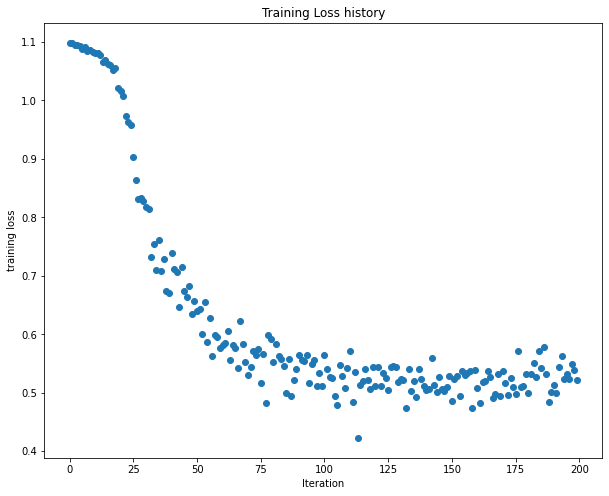

In [18]:
toy_X, toy_y, params = get_toy_data()

stats = nn_train(params, nn_loss_part2, nn_predict, toy_X, toy_y, toy_X, toy_y,
                 learning_rate=1e-1, reg=1e-6,
                 num_iters=200, verbose=False)
print(toy_X.shape)
print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'], 'o')
plt.xlabel('Iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

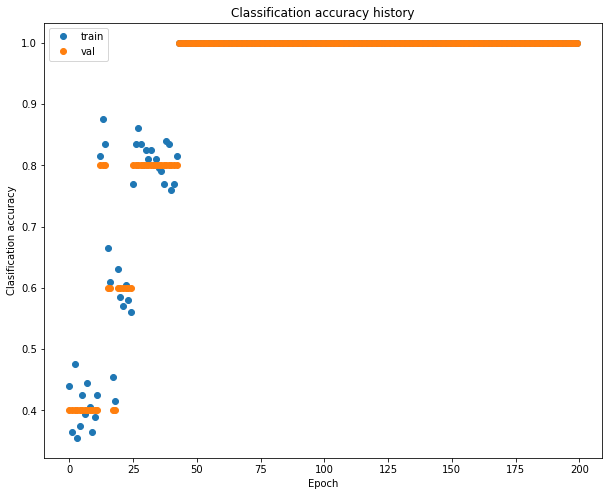

In [19]:
# Plot the loss function and train / validation accuracies
plt.plot(stats['train_acc_history'], 'o', label='train')
plt.plot(stats['val_acc_history'], 'o', label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

## Wrap all function into a Class
We will use the class `TwoLayerNet` to represent instances of our network. The network parameters are stored in the instance variable `self.params` where keys are string parameter names and values are PyTorch tensors.




In [20]:
class TwoLayerNet(object):
  def __init__(self, input_size, hidden_size, output_size, device='cuda',
               std=1e-4):
    """
    Initialize the model. Weights are initialized to small random values and
    biases are initialized to zero. Weights and biases are stored in the
    variable self.params, which is a dictionary with the following keys:

    W1: First layer weights; has shape (D, H)
    b1: First layer biases; has shape (H,)
    W2: Second layer weights; has shape (H, C)
    b2: Second layer biases; has shape (C,)

    Inputs:
    - input_size: The dimension D of the input data.
    - hidden_size: The number of neurons H in the hidden layer.
    - output_size: The number of classes C.
    """
    # fix random seed before we generate a set of parameters
    coutils.utils.fix_random_seed()

    self.params = {}
    self.params['W1'] = std * torch.randn(input_size, hidden_size, device=device)
    self.params['b1'] = torch.zeros(hidden_size, device=device)
    self.params['W2'] = std * torch.randn(hidden_size, output_size, device=device)
    self.params['b2'] = torch.zeros(output_size, device=device)

  def _loss(self, params, X, y=None, reg=0.0):
    return nn_loss_part2(params, X, y, reg)
  
  def loss(self, X, y=None, reg=0.0):
    return self._loss(self.params, X, y, reg)


  def _train(self, params, loss_func, pred_func, X, y, X_val, y_val,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=5e-6, num_iters=100,
            batch_size=200, verbose=False):
    return nn_train(params, loss_func, pred_func, X, y, X_val, y_val,
            learning_rate, learning_rate_decay,
            reg, num_iters, batch_size, verbose)
    
  def train(self, X, y, X_val, y_val,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=5e-6, num_iters=100,
            batch_size=200, verbose=False):
    return self._train(self.params, self._loss, self._predict, 
                       X, y, X_val, y_val,
                       learning_rate, learning_rate_decay,
                       reg, num_iters, batch_size, verbose)

  def _predict(self, params, loss_func, X):
    return nn_predict(params, loss_func, X)
  
  def predict(self, X):
    return self._predict(self.params, self._loss, X)

## Load CIFAR-10 data
Now that you have implemented a two-layer network that passes gradient checks and works on toy data, it's time to load up our favorite CIFAR-10 data so we can use it to train a classifier on a real dataset.

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .


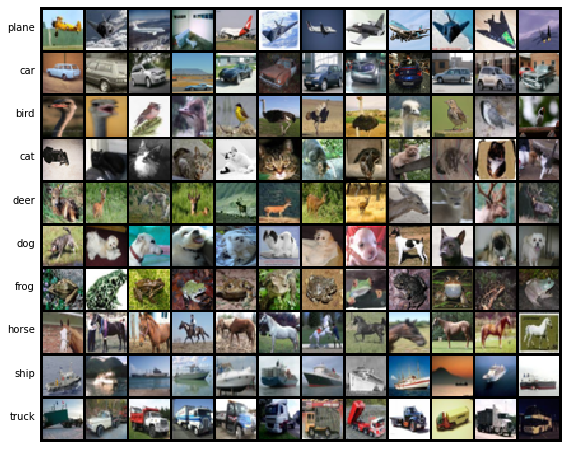

Train data shape:  torch.Size([47500, 3072])
Train labels shape:  torch.Size([47500])
Validation data shape:  torch.Size([2500, 3072])
Validation labels shape:  torch.Size([2500])
Test data shape:  torch.Size([10000, 3072])
Test labels shape:  torch.Size([10000])


In [21]:
def get_CIFAR10_data(validation_ratio = 0.05):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  X_train, y_train, X_test, y_test = coutils.data.cifar10()

  # load every data on cuda
  X_train = X_train.cuda()
  y_train = y_train.cuda()
  X_test = X_test.cuda()
  y_test = y_test.cuda()

  # 0. Visualize some examples from the dataset.
  class_names = [
      'plane', 'car', 'bird', 'cat', 'deer',
      'dog', 'frog', 'horse', 'ship', 'truck'
  ]
  img = coutils.utils.visualize_dataset(X_train, y_train, 12, class_names)
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  # 1. Normalize the data: subtract the mean RGB (zero mean)
  mean_image = X_train.mean(dim=0, keepdim=True).mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
  X_train -= mean_image
  X_test -= mean_image

  # 2. Reshape the image data into rows
  X_train = X_train.reshape(X_train.shape[0], -1)
  X_test = X_test.reshape(X_test.shape[0], -1)

  # 3. take the validation set from the training set
  # Note: It should not be taken from the test set
  # For random permumation, you can use torch.randperm or torch.randint
  # But, for this homework, we use slicing instead.
  num_training = int( X_train.shape[0] * (1.0 - validation_ratio) )
  num_validation = X_train.shape[0] - num_training

  # return the dataset
  data_dict = {}
  data_dict['X_val'] = X_train[num_training:num_training + num_validation]
  data_dict['y_val'] = y_train[num_training:num_training + num_validation]
  data_dict['X_train'] = X_train[0:num_training]
  data_dict['y_train'] = y_train[0:num_training]

  data_dict['X_test'] = X_test
  data_dict['y_test'] = y_test
  return data_dict

# Invoke the above function to get our data.
data_dict = get_CIFAR10_data()
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

## Train a network
To train our network we will use SGD. In addition, we will adjust the learning rate with an exponential decay learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [22]:
input_size = 3 * 32 * 32
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(data_dict['X_train'], data_dict['y_train'],
                  data_dict['X_val'], data_dict['y_val'],
                  num_iters=1000, batch_size=200,
                  learning_rate=1e-4, learning_rate_decay=0.95,
                  reg=0.25, verbose=True)

# Predict on the validation set
y_val_pred = net.predict(data_dict['X_val'])
val_acc = 100.0 * (y_val_pred == data_dict['y_val']).float().mean().item()
print('Validation accuracy: %.2f%%' % val_acc)

iteration 0 / 1000: loss 2.302971
iteration 100 / 1000: loss 2.302970
iteration 200 / 1000: loss 2.302967
iteration 300 / 1000: loss 2.302959
iteration 400 / 1000: loss 2.302959
iteration 500 / 1000: loss 2.302955
iteration 600 / 1000: loss 2.302948
iteration 700 / 1000: loss 2.302947
iteration 800 / 1000: loss 2.302941
iteration 900 / 1000: loss 2.302942
Validation accuracy: 9.64%


## Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 8.76% on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

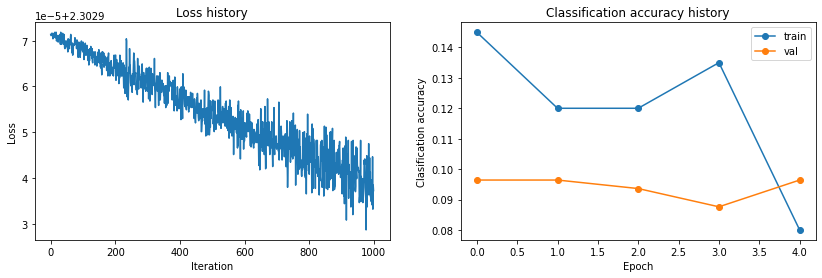

In [23]:
# Plot the loss function and train / validation accuracies
def plot_stats(stat_dict):
  plt.subplot(1, 2, 1)
  plt.plot(stat_dict['loss_history'], '-')
  plt.title('Loss history')
  plt.xlabel('Iteration')
  plt.ylabel('Loss')

  plt.subplot(1, 2, 2)
  plt.plot(stat_dict['train_acc_history'], 'o-', label='train')
  plt.plot(stat_dict['val_acc_history'], 'o-', label='val')
  plt.title('Classification accuracy history')
  plt.xlabel('Epoch')
  plt.ylabel('Clasification accuracy')
  plt.legend()
  
  plt.gcf().set_size_inches(14, 4)
  plt.show()

plot_stats(stats)

Similar to SVM and Softmax classifier, let's visualize the weights.

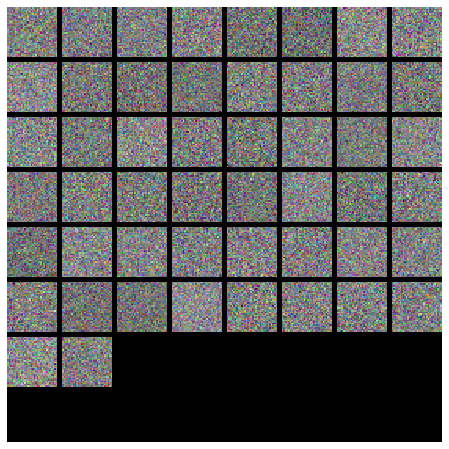

In [24]:
def visualize_grid(Xs, ubound=255.0, padding=1):
  """
  Reshape a 4D tensor of image data to a grid for easy visualization.

  Inputs:
  - Xs: Data of shape (N, H, W, C)
  - ubound: Output grid will have values scaled to the range [0, ubound]
  - padding: The number of blank pixels between elements of the grid
  """
  (N, H, W, C) = Xs.shape
  # print(Xs.shape)
  grid_size = int(math.ceil(math.sqrt(N)))
  grid_height = H * grid_size + padding * (grid_size - 1)
  grid_width = W * grid_size + padding * (grid_size - 1)
  grid = torch.zeros((grid_height, grid_width, C), device=Xs.device)
  next_idx = 0
  y0, y1 = 0, H
  for y in range(grid_size):
    x0, x1 = 0, W
    for x in range(grid_size):
      if next_idx < N:
        img = Xs[next_idx]
        low, high = torch.min(img), torch.max(img)
        grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
        # grid[y0:y1, x0:x1] = Xs[next_idx]
        next_idx += 1
      x0 += W + padding
      x1 += W + padding
    y0 += H + padding
    y1 += H + padding
  # print(grid.shape)
  return grid


# Visualize the weights of the network
def show_net_weights(net):
  W1 = net.params['W1']
  W1 = W1.reshape(3, 32, 32, -1).transpose(0, 3)
  plt.imshow(visualize_grid(W1, padding=3).type(torch.uint8).cpu())
  plt.gca().axis('off')
  plt.show()

show_net_weights(net)

## What's wrong?
Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

### Capacity?
Our initial model has very similar performance on the training and validation sets. This suggests that the model is underfitting, and that its performance might improve if we were to increase its capacity.

One way we can increase the capacity of a neural network model is to increase the size of its hidden layer. Here we investigate the effect of increasing the size of the hidden layer. The performance (as measured by validation-set accuracy) should increase as the size of the hidden layer increases; however it may show diminishing returns for larger layer sizes.

In [25]:
def plot_acc_curves(stat_dict):
  plt.subplot(1, 2, 1)
  for key, single_stats in stat_dict.items():
    plt.plot(single_stats['train_acc_history'], label=str(key))
  plt.title('Train accuracy history')
  plt.xlabel('Epoch')
  plt.ylabel('Clasification accuracy')

  plt.subplot(1, 2, 2)
  for key, single_stats in stat_dict.items():
    plt.plot(single_stats['val_acc_history'], label=str(key))
  plt.title('Validation accuracy history')
  plt.xlabel('Epoch')
  plt.ylabel('Clasification accuracy')
  plt.legend()

  plt.gcf().set_size_inches(14, 5)
  plt.show()

train with hidden size: 2
train with hidden size: 8
train with hidden size: 32
train with hidden size: 128
train with hidden size: 512


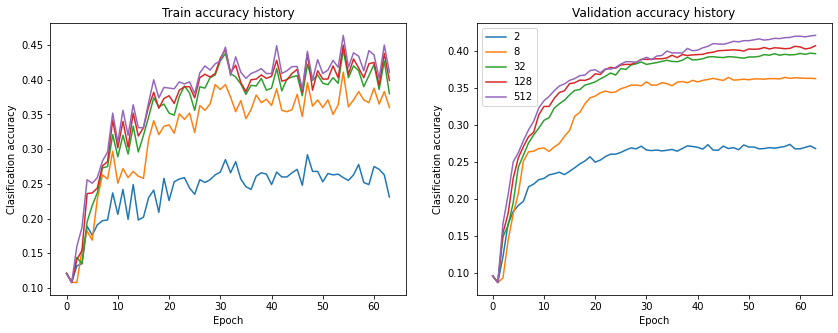

In [26]:
hidden_sizes = [2, 8, 32, 128, 512] 
lr = 0.1
reg = 0.001

stat_dict = {}
for hs in hidden_sizes:
  print('train with hidden size: {}'.format(hs))
  net = TwoLayerNet(3 * 32 * 32, hs, 10, device=data_dict['X_train'].device)
  stats = net.train(data_dict['X_train'], data_dict['y_train'], data_dict['X_val'], data_dict['y_val'],
            num_iters=3000, batch_size=1000,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=reg, verbose=False)
  stat_dict[hs] = stats

plot_acc_curves(stat_dict)

### Regularization?
Another possible explanation for the small gap we saw between the train and validation accuracies of our model is regularization. In particular, if the regularization coefficient were too high then the model may be unable to fit the training data.

We can investigate the phenomenon empirically by training a set of models with varying regularization strengths while fixing other hyperparameters.

You should see that setting the regularization strength too high will harm the validation-set performance of the model:

train with regularization: 0
train with regularization: 1e-05
train with regularization: 0.0001
train with regularization: 0.001
train with regularization: 0.01
train with regularization: 0.1


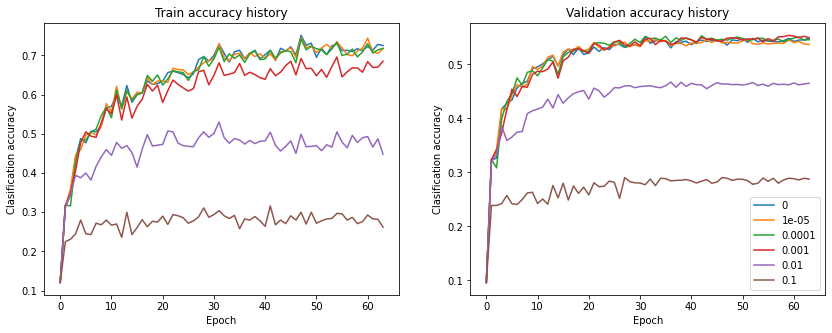

In [27]:
hs = 128
lr = 1.0
regs = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

stat_dict = {}
for reg in regs:
  print('train with regularization: {}'.format(reg))
  net = TwoLayerNet(3 * 32 * 32, hs, 10, device=data_dict['X_train'].device)
  stats = net.train(data_dict['X_train'], data_dict['y_train'], data_dict['X_val'], data_dict['y_val'],
            num_iters=3000, batch_size=1000,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=reg, verbose=False)
  stat_dict[reg] = stats

plot_acc_curves(stat_dict)

### Learning Rate?
Last but not least, we also want to see the effect of learning rate with respect to the performance.

train with learning rate: 0.001
train with learning rate: 0.01
train with learning rate: 0.1
train with learning rate: 1.0
train with learning rate: 10.0


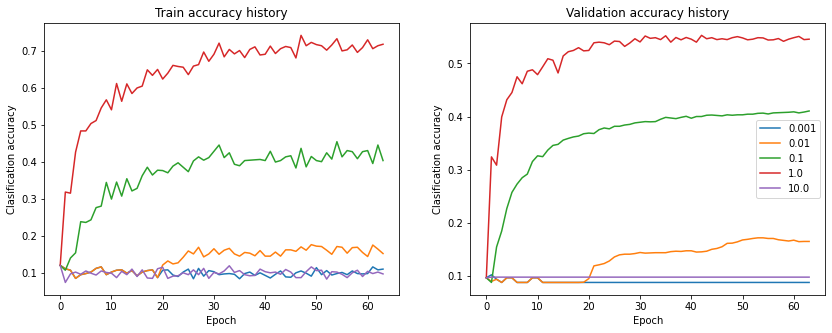

In [28]:
hs = 128
lrs = [1e-3, 1e-2, 1e-1, 1e0, 1e1]
reg = 1e-4

stat_dict = {}
for lr in lrs:
  print('train with learning rate: {}'.format(lr))
  net = TwoLayerNet(3 * 32 * 32, hs, 10, device=data_dict['X_train'].device)
  stats = net.train(data_dict['X_train'], data_dict['y_train'], data_dict['X_val'], data_dict['y_val'],
            num_iters=3000, batch_size=1000,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=reg, verbose=False)
  stat_dict[lr] = stats

plot_acc_curves(stat_dict)

## Tune your hyperparameters

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, number of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Plots**. To guide your hyperparameter search, you might consider making auxiliary plots of training and validation performance as above, or plotting the results arising from different hyperparameter combinations as we did in the Linear Classifier notebook. You should feel free to plot any auxiliary results you need in order to find a good network, but we don't require any particular plots from you.

**Approximate results**. To get full credit for the assignment, you should achieve a classification accuracy above 50% on the validation set.

(Our best model gets a validation-set accuracy above 58% -- did you beat us?)

Training with lr: 0.5062268131138772, hidden:32, num_iters:6863
Training with lr: 0.4156289470832243, hidden:162, num_iters:2738
Training with lr: 0.4269537545187787, hidden:54, num_iters:7615
Training with lr: 0.7368500427427801, hidden:35, num_iters:3644
Training with lr: 0.8202490876243038, hidden:149, num_iters:6548
Training with lr: 0.8769339020229788, hidden:104, num_iters:5401
Training with lr: 0.0581997686237532, hidden:155, num_iters:3892
Training with lr: 0.8324962041408626, hidden:117, num_iters:9001
Training with lr: 0.9219262065190044, hidden:159, num_iters:7393
Training with lr: 0.08175174765267523, hidden:85, num_iters:5640
Training with lr: 0.39721779822629544, hidden:133, num_iters:5862
Training with lr: 0.9572789973550297, hidden:111, num_iters:7235
Training with lr: 0.33636942385673985, hidden:180, num_iters:6766
Training with lr: 0.30760993169122175, hidden:61, num_iters:9095
Training with lr: 0.9491893766912173, hidden:137, num_iters:2895
Training with lr: 0.195953

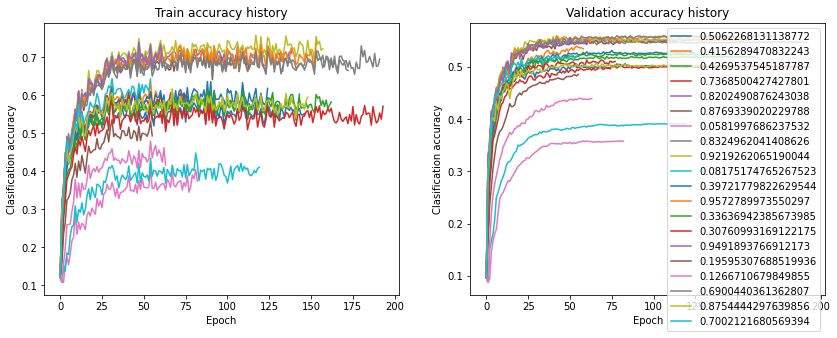

In [41]:
import random

best_net = None # store the best model into this
best_validation_score = 0

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################
# Replace "pass" statement with your code
# hss = [50, 80, 100, 120, 150, 170, 190, 210]
# reg = 1e-4
# lrs = [1e0]
# lr_decay = 0.95
# num_iters = 4e3

hidden_range = [30, 220]
reg = 1e-4
lr_range = [1e0, 1e-3]
lr_decay = 0.95
num_iters_range = [1e3, 1e4]

stat_dict = {}
for attempt in range(20):
  random.seed()
  hidden = int(random.uniform(hidden_range[0], hidden_range[1]))
  lr = random.uniform(lr_range[0], lr_range[1])
  num_iters = int(random.uniform(num_iters_range[0], num_iters_range[1]))
  print(f"Training with lr: {lr}, hidden:{hidden}, num_iters:{num_iters}")

  net = TwoLayerNet(3 * 32 * 32, hidden, 10, device=data_dict['X_train'].device)
  stats = net.train(data_dict['X_train'], data_dict['y_train'], data_dict['X_val'], data_dict['y_val'],
            num_iters=num_iters, batch_size=1000,
            learning_rate=lr, learning_rate_decay=lr_decay,
            reg=reg, verbose=False)
  stat_dict[lr] = stats
  if stats['val_acc_history'][-1] > best_validation_score:
    best_validation_score = stats['val_acc_history'][-1]
    best_net = net

plot_acc_curves(stat_dict)

#################################################################################
#                               END OF YOUR CODE                                #
#################################################################################

In [42]:
# Check the validation-set accuracy of your best model
y_val_preds = best_net.predict(data_dict['X_val'])
val_acc = 100 * (y_val_preds == data_dict['y_val']).float().mean().item()
print('Best val-set accuracy: %.2f%%' % val_acc)

Best val-set accuracy: 56.00%


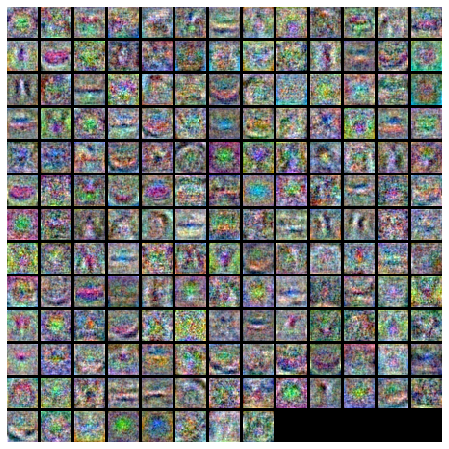

In [43]:
# visualize the weights of the best network
show_net_weights(best_net)

## Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set. To get full credit for the assignment, you should achieve over 50% classification accuracy on the test set.

(Our best model gets 54.1% test-set accuracy -- did you beat us?)

In [44]:
y_test_preds = best_net.predict(data_dict['X_test'])
test_acc = 100 * (y_test_preds == data_dict['y_test']).float().mean().item()
print('Test accuracy: %.2f%%' % test_acc)

Test accuracy: 53.50%
